<a href="https://colab.research.google.com/github/Freesoul-tech/Louis-Mahobe/blob/main/Conv2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np

class Conv2d:
    def __init__(self, in_channels, out_channels, filter_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        self.W = np.random.randn(out_channels, in_channels, *filter_size) * 0.1
        self.b = np.zeros(out_channels)

    def forward(self, x):
        N, C, H, W = x.shape
        FH, FW = self.filter_size
        SH, SW = self.stride, self.stride
        PH, PW = self.padding, self.padding

        # Pad input
        x_padded = np.pad(x, ((0,0), (0,0), (PH,PH), (PW,PW)), mode='constant')

        # Output dimensions
        H_out = (H + 2*PH - FH) // SH + 1
        W_out = (W + 2*PW - FW) // SW + 1
        out = np.zeros((N, self.out_channels, H_out, W_out))

        # Convolution
        for n in range(N):
            for m in range(self.out_channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * SH
                        w_start = j * SW
                        region = x_padded[n, :, h_start:h_start+FH, w_start:w_start+FW]
                        out[n, m, i, j] = np.sum(region * self.W[m]) + self.b[m]
        return out


In [14]:
import numpy as np

# Input: shape (1, 1, 4, 4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])

# Filters: shape (2, 1, 3, 3)
w = np.array([
    [[[ 0.,  0.,  0.],
      [ 0.,  1.,  0.],
      [ 0., -1.,  0.]]],

    [[[ 0.,  0.,  0.],
      [ 0., -1.,  1.],
      [ 0.,  0.,  0.]]]
])

# Biases: shape (2,)
b = np.array([0., 0.])


In [15]:
def conv2d_forward(x, w, b, stride=1, padding=0):
    N, C_in, H, W = x.shape
    C_out, _, FH, FW = w.shape
    H_out = (H + 2 * padding - FH) // stride + 1
    W_out = (W + 2 * padding - FW) // stride + 1

    x_padded = np.pad(x, ((0,0), (0,0), (padding,padding), (padding,padding)), mode='constant')
    out = np.zeros((N, C_out, H_out, W_out))

    for n in range(N):
        for m in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride
                    region = x_padded[n, :, h_start:h_start+FH, w_start:w_start+FW]
                    out[n, m, i, j] = np.sum(region * w[m]) + b[m]
    return out


In [16]:
out = conv2d_forward(x, w, b)
print(np.round(out[0], 2))


[[[-4. -4.]
  [-4. -4.]]

 [[ 1.  1.]
  [ 1.  1.]]]


In [17]:
def compute_output_size(N_in, F, P, S):
    return (N_in + 2 * P - F) // S + 1


In [18]:
import numpy as np

class MaxPool2D:
    def __init__(self, pool_size=(2, 2), stride=2):
        self.pool_size = pool_size
        self.stride = stride
        self.cache = None  # backward pass

    def forward(self, x):
        N, C, H, W = x.shape
        PH, PW = self.pool_size
        SH = SW = self.stride

        H_out = (H - PH) // SH + 1
        W_out = (W - PW) // SW + 1
        out = np.zeros((N, C, H_out, W_out))

        self.cache = {}  # Store max indices for backward

        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * SH
                        w_start = j * SW
                        region = x[n, c, h_start:h_start+PH, w_start:w_start+PW]
                        max_val = np.max(region)
                        out[n, c, i, j] = max_val


                        max_idx = np.unravel_index(np.argmax(region), region.shape)
                        self.cache[(n, c, i, j)] = (h_start + max_idx[0], w_start + max_idx[1])
        return out


In [19]:
def backward(self, dout):
    N, C, H_out, W_out = dout.shape
    PH, PW = self.pool_size
    SH = SW = self.stride

    dx = np.zeros((N, C, H_out * SH, W_out * SW))

    for n in range(N):
        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):
                    h_idx, w_idx = self.cache[(n, c, i, j)]
                    dx[n, c, h_idx, w_idx] += dout[n, c, i, j]
    return dx


In [20]:
x = np.array([[[[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9,10,11,12],
                [13,14,15,16]]]])

pool = MaxPool2D(pool_size=(2,2), stride=2)
out = pool.forward(x)
print(out)


[[[[ 6.  8.]
   [14. 16.]]]]


In [21]:
import numpy as np

class AveragePool2D:
    def __init__(self, pool_size=(2, 2), stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, x):
        N, C, H, W = x.shape
        PH, PW = self.pool_size
        SH = SW = self.stride

        H_out = (H - PH) // SH + 1
        W_out = (W - PW) // SW + 1
        out = np.zeros((N, C, H_out, W_out))

        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * SH
                        w_start = j * SW
                        region = x[n, c, h_start:h_start+PH, w_start:w_start+PW]
                        out[n, c, i, j] = np.mean(region)
        return out


In [22]:
x = np.array([[[[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9,10,11,12],
                [13,14,15,16]]]])

pool = AveragePool2D(pool_size=(2,2), stride=2)
out = pool.forward(x)
print(np.round(out, 2))


[[[[ 3.5  5.5]
   [11.5 13.5]]]]


In [23]:
def backward(self, dout):
    N, C, H_out, W_out = dout.shape
    PH, PW = self.pool_size
    SH = SW = self.stride

    dx = np.zeros((N, C, H_out * SH, W_out * SW))

    for n in range(N):
        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * SH
                    w_start = j * SW
                    dx[n, c, h_start:h_start+PH, w_start:w_start+PW] += dout[n, c, i, j] / (PH * PW)
    return dx


In [24]:
import numpy as np

class Flatten:
    def __init__(self):
        self.original_shape = None

    def forward(self, x):
        self.original_shape = x.shape
        N = x.shape[0]
        return x.reshape(N, -1)

    def backward(self, dout):
        return dout.reshape(self.original_shape)


In [25]:
x = np.random.randn(2, 3, 4, 4)
flatten = Flatten()

out = flatten.forward(x)
print("Flattened shape:", out.shape)

dx = flatten.backward(out)
print("Restored shape:", dx.shape)


Flattened shape: (2, 48)
Restored shape: (2, 3, 4, 4)


In [26]:
class FullyConnected:
    def __init__(self, input_dim, output_dim):
        self.W = np.random.randn(input_dim, output_dim) * 0.1
        self.b = np.zeros(output_dim)
    def forward(self, x):
        return x @ self.W + self.b


In [27]:
from keras.datasets import mnist
from keras.utils import to_categorical

# Load and preprocess
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 1, 28, 28) / 255.0
x_test = x_test.reshape(-1, 1, 28, 28) / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [28]:
class Scratch2dCNNClassifier:
    def __init__(self):
        self.conv = Conv2d(in_channels=1, out_channels=4, filter_size=(3,3), stride=1, padding=1)
        self.pool = MaxPool2D(pool_size=(2,2), stride=2)
        self.flatten = Flatten()
        self.fc = FullyConnected(input_dim=4*14*14, output_dim=10)

    def forward(self, x):
        x = self.conv.forward(x)
        x = np.maximum(0, x)
        x = self.pool.forward(x)
        x = self.flatten.forward(x)
        out = self.fc.forward(x)
        return out


In [32]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy(pred, target):
    return -np.sum(target * np.log(pred + 1e-8)) / pred.shape[0]

model = Scratch2dCNNClassifier()
lr = 0.01
epochs = 1
batch_size = 5

for epoch in range(epochs):
  for i in range(0, batch_size * 5, batch_size):

        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        logits = model.forward(x_batch)
        probs = softmax(logits)
        loss = cross_entropy(probs, y_batch)


        print(f"Epoch {epoch+1}, Batch {i//batch_size+1}, Loss: {loss:.4f}")


Epoch 1, Batch 1, Loss: 2.3255
Epoch 1, Batch 2, Loss: 2.1882
Epoch 1, Batch 3, Loss: 2.2517
Epoch 1, Batch 4, Loss: 2.3444
Epoch 1, Batch 5, Loss: 2.3848


In [33]:
def accuracy(model, x, y):
    logits = model.forward(x)
    preds = np.argmax(logits, axis=1)
    labels = np.argmax(y, axis=1)
    return np.mean(preds == labels)

acc = accuracy(model, x_test[:1000], y_test[:1000])
print(f"Test Accuracy (first 1000 samples): {acc:.4f}")


Test Accuracy (first 1000 samples): 0.1330


In [34]:
class LeNetModern:
    def __init__(self):
        self.conv1 = Conv2d(in_channels=1, out_channels=6, filter_size=(5,5), stride=1, padding=0)
        self.pool1 = MaxPool2D(pool_size=(2,2), stride=2)
        self.conv2 = Conv2d(in_channels=6, out_channels=16, filter_size=(5,5), stride=1, padding=0)
        self.pool2 = MaxPool2D(pool_size=(2,2), stride=2)
        self.flatten = Flatten()
        self.fc1 = FullyConnected(input_dim=16*4*4, output_dim=120)
        self.fc2 = FullyConnected(input_dim=120, output_dim=84)
        self.fc3 = FullyConnected(input_dim=84, output_dim=10)

    def forward(self, x):
        x = self.conv1.forward(x)
        x = np.maximum(0, x)
        x = self.pool1.forward(x)
        x = self.conv2.forward(x)
        x = np.maximum(0, x)
        x = self.pool2.forward(x)
        x = self.flatten.forward(x)
        x = np.maximum(0, self.fc1.forward(x))
        x = np.maximum(0, self.fc2.forward(x))
        x = self.fc3.forward(x)
        return x


In [35]:
class LeNetModern:
    def __init__(self):
        self.conv1 = Conv2d(1, 6, (5,5), stride=1, padding=0)
        self.pool1 = MaxPool2D((2,2), stride=2)
        self.conv2 = Conv2d(6, 16, (5,5), stride=1, padding=0)
        self.pool2 = MaxPool2D((2,2), stride=2)
        self.flatten = Flatten()
        self.fc1 = FullyConnected(16*4*4, 120)
        self.fc2 = FullyConnected(120, 84)
        self.fc3 = FullyConnected(84, 10)

    def forward(self, x):
        x = np.maximum(0, self.conv1.forward(x))
        x = self.pool1.forward(x)
        x = np.maximum(0, self.conv2.forward(x))
        x = self.pool2.forward(x)
        x = self.flatten.forward(x)
        x = np.maximum(0, self.fc1.forward(x))
        x = np.maximum(0, self.fc2.forward(x))
        return self.fc3.forward(x)


In [36]:
model = LeNetModern()
acc = accuracy(model, x_test[:1000], y_test[:1000])
print(f"Test Accuracy (first 1000 samples): {acc:.4f}")


Test Accuracy (first 1000 samples): 0.1350


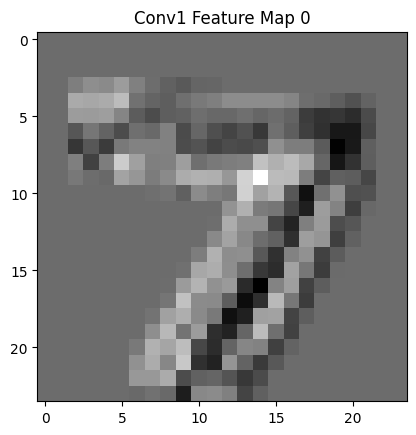

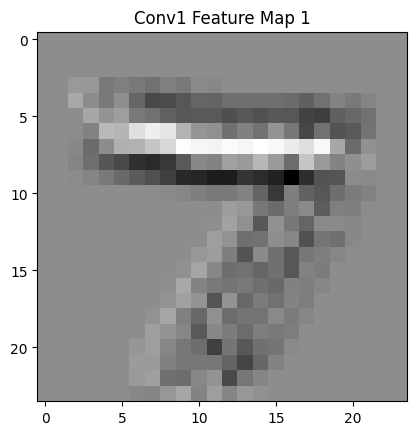

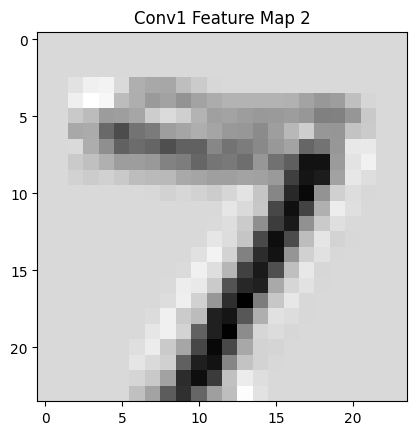

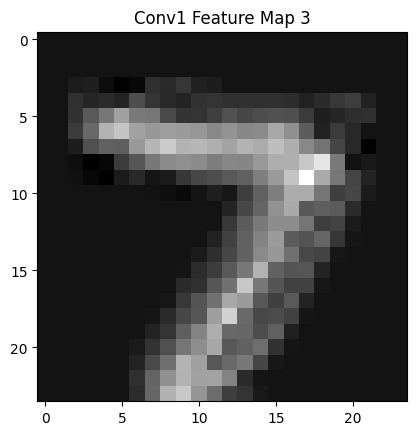

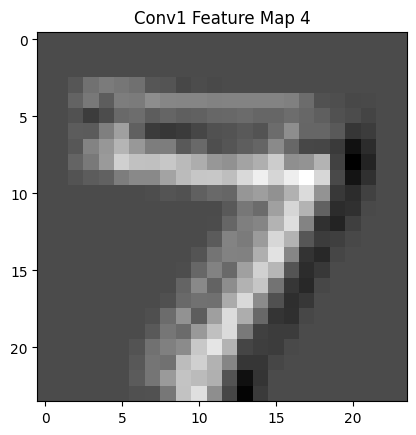

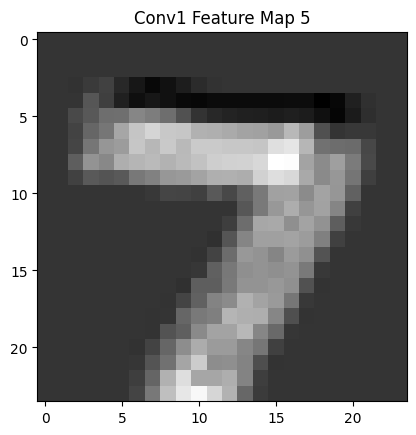

In [37]:
features = model.conv1.forward(x_test[:1])
import matplotlib.pyplot as plt

for i in range(features.shape[1]):
    plt.imshow(features[0, i], cmap='gray')
    plt.title(f'Conv1 Feature Map {i}')
    plt.show()


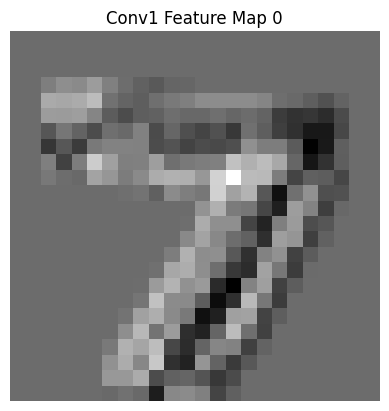

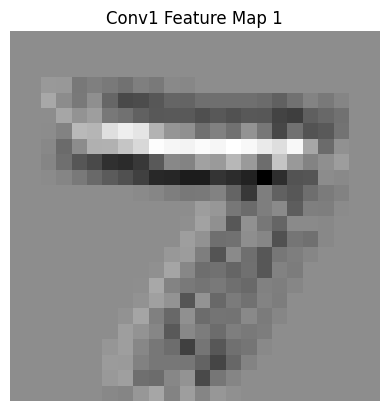

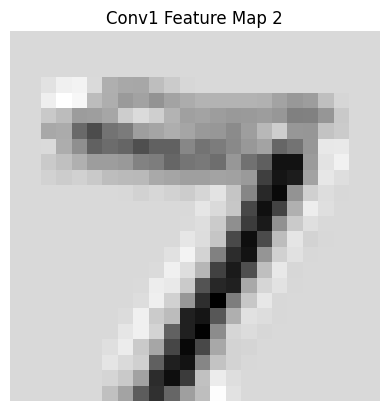

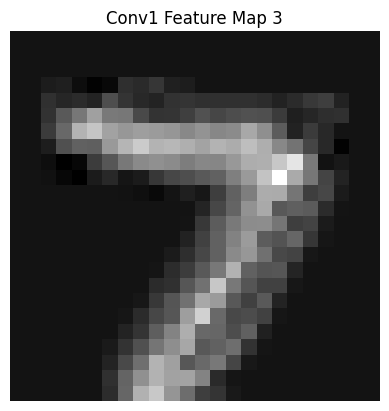

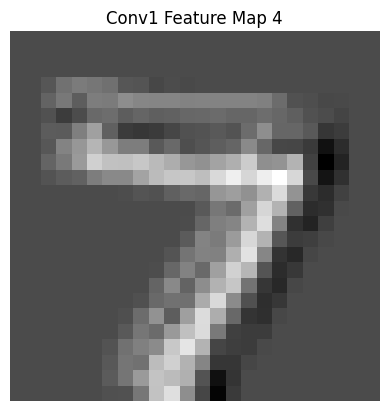

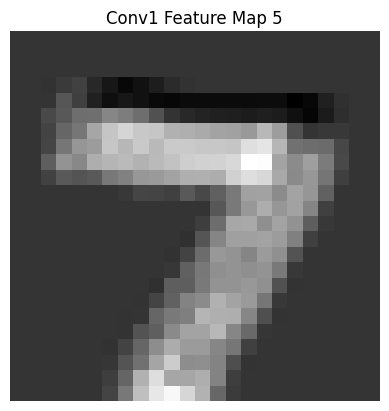

In [38]:
import matplotlib.pyplot as plt

# first test image
x_sample = x_test[:1]  # Shape: (1, 1, 28, 28)

# Forward pass through conv1
features1 = model.conv1.forward(x_sample)

# Plot each feature map
for i in range(features1.shape[1]):
    plt.imshow(features1[0, i], cmap='gray')
    plt.title(f'Conv1 Feature Map {i}')
    plt.axis('off')
    plt.show()


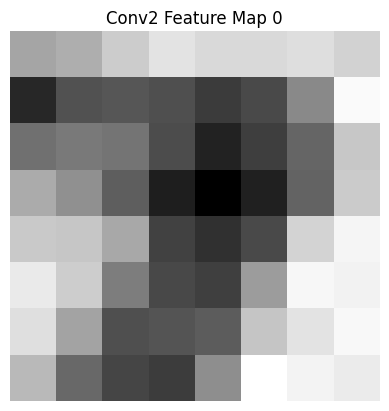

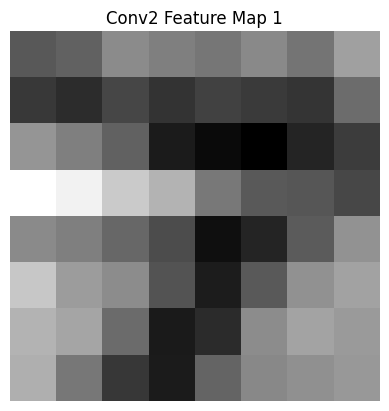

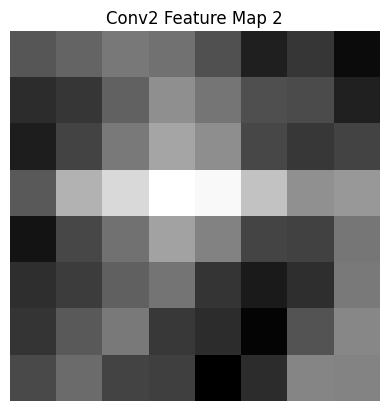

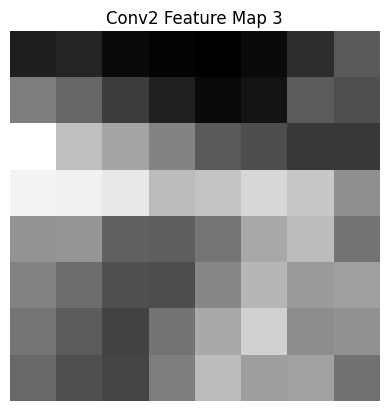

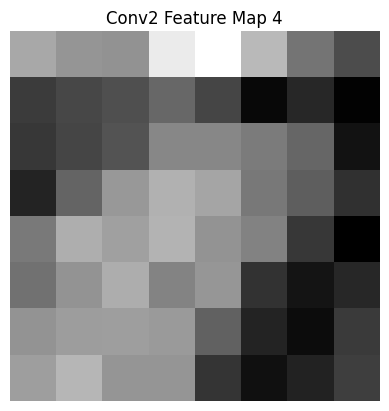

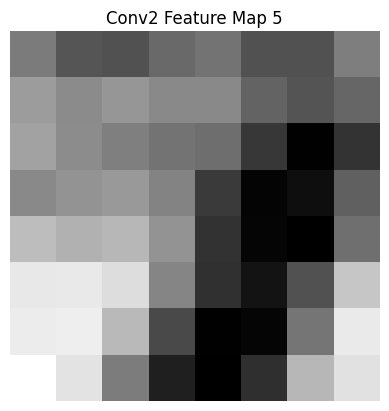

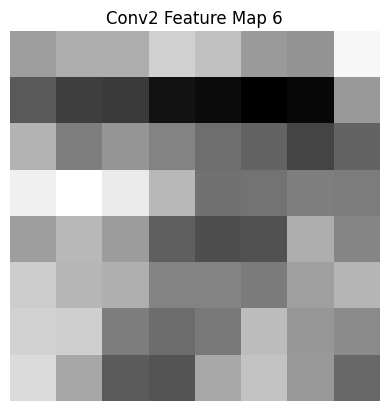

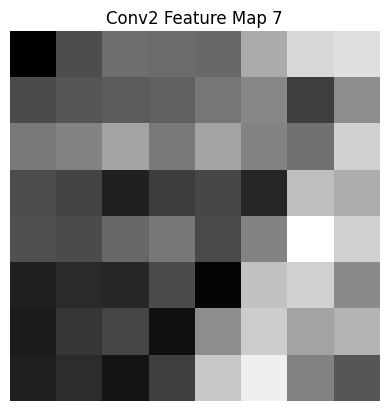

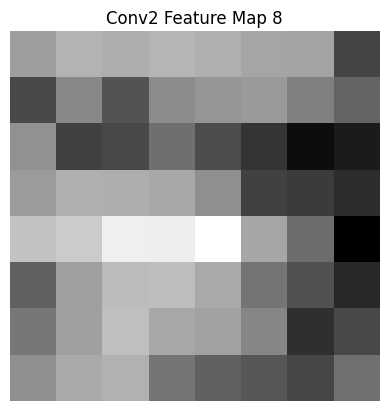

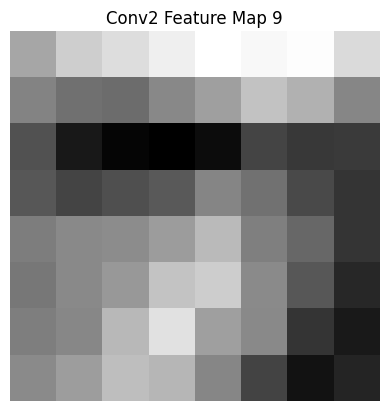

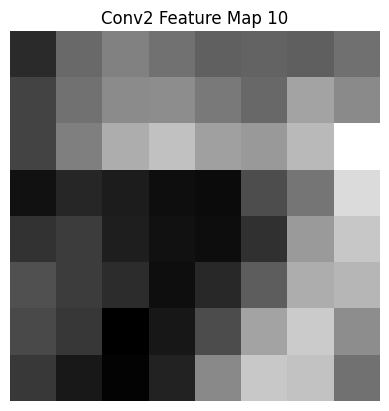

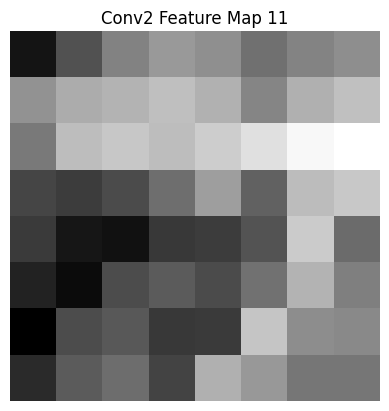

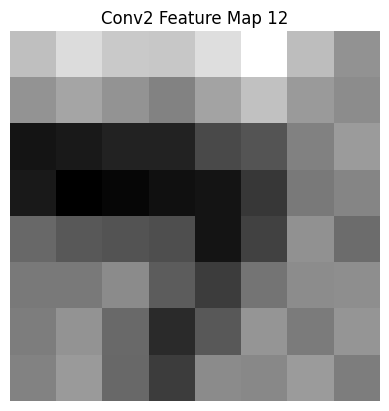

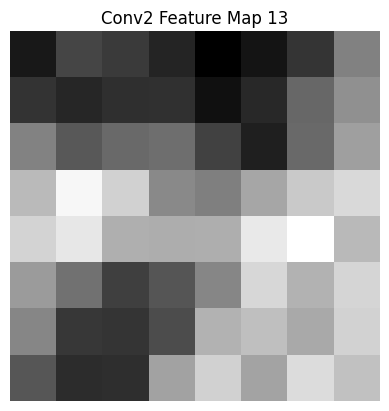

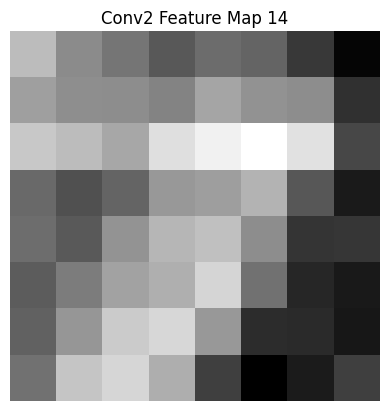

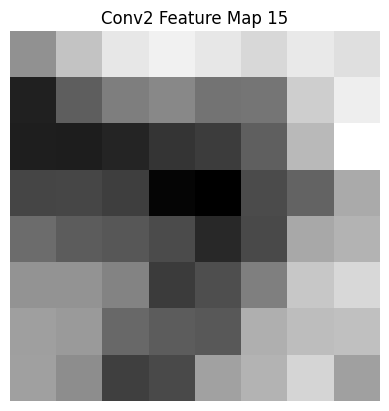

In [39]:
# Forward through conv1 + ReLU + pool1
x = np.maximum(0, model.conv1.forward(x_sample))
x = model.pool1.forward(x)

# Forward through conv2
features2 = model.conv2.forward(x)

# Plot each feature map
for i in range(features2.shape[1]):
    plt.imshow(features2[0, i], cmap='gray')
    plt.title(f'Conv2 Feature Map {i}')
    plt.axis('off')
    plt.show()
